In [1]:
import numpy as np
import stressfit.commands as comm
import stressfit.shapes as shapes
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>To hide/show the code blocks, click <a href="javascript:code_toggle()">here</a>.</b>''')

# STRESSFIT
<p>
<i>Written by:</i> Jan Saroun, Nuclear Physics Institute CAS, Rez, saroun@ujf.cas.cz<br/>
<i>Date:</i> 03/20/2023<br/>
<i>Source:</i> <a href='https://github.com/NPLtools/stressfit'>https://github.com/NPLtools/stressfit</a>
</p>
<p>
This script implements common workflow for the data treatment with StressFit. On the input, STRESFIT uses a list of neutron scattering events with associated data (position, wave vectors, weight factor and "as-measured" lattice spacing - $d_{hkl}$}) accessible at given instrument setup. This list describes the instrumental sampling distribution independently on the sample. It can be obtained by ray-tracing simulation of the instrument using appropriate software, such as McStas (<a href='http://mcstas.org'>http://mcstas.org</a>) or SIMRES (<a href='https://github.com/saroun/simres'>https://github.com/saroun/simres</a>). 

STRESSFIT provides tools for 3D convolution of such a sampling list with the sample model and permits to calculate: 

- “centre of gravity” and size of the neutron sampling volume as a function of sample position (in 3D),
- variation of intensity and position of diffraction peaks due to the perturbation of sampling distribution (material boundaries, absorption, composition and texture gradients),
- “as measured” (smeared) intensity and strain distributions including the pseudo-strain effects,
- least-squares fit of intrinsic strain and intensity distributions.

</p><p>
STRESSFIT enables to model pseudo-strains for several sample shapes such as curved plates, cylinders, spheres, tubes (both single- and multi-channel) and polygonal rods. Neutron attenuation tables for several common materials generated with the help of the NCrystal library (<a href='https://github.com/mctools/ncrystal'>https://github.com/mctools/ncrystal</a>) are provided as a part of the package resources. Currently, STRESSFIT allows for least squares fitting of measured scans for a single strain component. Simultaneous fitting of multiple strain or stress tensor components is envisaged in future versions.
</p>    

## Jupyter viewer

User interface based on Jupyter notebook widgets can be launched by executing the code:
<code>  
import stressfit.ui.notebook as nb  
ui = nb.UI()  
ui.display()  
</code> 
    
Script examples with output of STRESSFIT are also available via Jupyter viewer server:
<p>
<a href='http://nbviewer.jupyter.org/url/neutron.ujf.cas.cz/restrax/download/stressfit/stressfit_example1.ipynb'>
Example 1</a>: ECNS2019, Fitting of strain gradient under the inner surface of a tube, test on synthetic data for STRESS-SPEC.
</p>

## Documentation
<p>
For more information and use examples, see: <br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/ECRS2018_stressfit.pdf'>ECRS10, 2018, slides</a><br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/saroun_ECNS2019_poster.pdf'>ECNS 2019, poster</a> <br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/stressfit_ECNS2023_poster.pdf'>ECNS 2023, poster</a> <br/>
</p>

## Workspace definition

Set the directories for your workspace:

`workspace`: root directory, should be an absolute path  
`data`: input path for sampling and experimental data  
`tables`: input path for lookup tables etc.  
`output`: output path for all results

Relative paths should exist under the workspace root directory.
Set input path to `None` for searching in package resources.

In [2]:
"""Set the root workspace directory. Use None for the current directory."""
workspace = None

"""Set the other input/output folders (can be absolute or relative).
Relative paths should exist under the workspace directory.
Set to None for searching in package resources.
"""
env = {'output': './output', # output path (./output is the default if None)
       'data': None,         # input path for sampling and experimental data 
       'tables': None        # input path for lookup tables etc.
      }

# Set workspace and validate
comm.set_workspace(workspace)
comm.set_environment(**env)
comm.validate_workspace()

Loaded workspace setting from C:\Users\saroun\Documents\stressfit\.stressfit\workspace.json
Workspace setting:
work: C:/Users/saroun/Documents/stressfit
data: D:/Saroun/git/stressfit_ecns/stressfit/resources/data
tables: D:/Saroun/git/stressfit_ecns/stressfit/resources/tables
instruments: D:/Saroun/git/stressfit_ecns/stressfit/resources/instruments
output: C:/Users/saroun/Documents/stressfit/output


## Sample shape

Sample shape can be created by the function `shape.create(ID, **kwargs)`, which take the shape ID string and other named parameters (kwargs) as the arguments. The ID's are defined as constants in the shapes module. The named parameters depend on the shape type. For example,
<code> S.create(shapes.Plate, thickness=10.0) </code> defines an infinitely large flat plate of given thickness. Dimensions are in mm. For documentation on other shapes, execute the command `shapes.help()`.

In [3]:
shapes.help()

Call create(shape, **kwargs) to create an instance of sample shape.

--------------------------------------------------
stressfit.shapes.create
--------------------------------------------------

Create an instance of a shape class.
     
     Parameters
     ----------
     shape:
     One of the shape ID constant defined by this package:
     
     - stressfit.shapes.Plate 
     - stressfit.shapes.PlateCurved
     - stressfit.shapes.Cylinder
     - stressfit.shapes.Tube
     - stressfit.shapes.Sphere
     - stressfit.shapes.Shell
     - stressfit.shapes.Tubes
     - stressfit.shapes.ETubes
     - stressfit.shapes.PolygonBar
    
     **kwargs:
     Named arguments to the shape constructor.
     Use stressfit.shapes.help() to print detailed information.
     
    

--------------------------------------------------
stressfit.shapes.Plate
--------------------------------------------------

Define infinite plate normal to z.
    
    Parameters
    ----------
    thickness: float
      

In [4]:
# Define a tube-like sample
# sref=0 means that the depth is measured from the outer surface ...
shape_param = {'Rin':4.0, 'Rout':8.0, 'height':50.0, 'sref':1}
# execute
comm.set_shape(shapes.Tube, **shape_param)

## Geometry

The geometry data include four vectors:

`angles`: Defines sample rotation with respect to the laboratory frame. The laboratory frame is defined by y-axis vertical and z-axis pointing along the incident beam. The orientation is described by YXY Euler angles in deg.  
`rotctr`: Sample rotation centre (in sample coordinates).  
`scandir`: Scan direction in sample coordinates (where the gauge moves relative to sample)  
`scanorig`: Scan origin in sample coordinates. It is the point corresponding to the zero encoder value (x-value in the input data).

In [5]:
"""Define scan geometry."""
geom = {
# Scan direction in sample coordinates (where the gauge moves)
'scandir': [0., 0., -1.],
# Sample orientation (Euler angles YXY) in deg
'angles': [135, 0, 0],
# Scan origin (encoder = 0) in sample coordinates
'scanorig':[0, 0, 0],
# Sample rotation centre (sample coordinates)
'rotctr': [0, 0, 0]
}
# execute
comm.set_geometry(geom)

## Material

Define material attenuation, either of:
    
- File name: A table with 2 columns (wavelength [A], attenuation [1/cm])
- Float number: attenuation [1/cm]

Example data files can be found in the package resources. Other files should be placed in the `tables` directory of the current workspace.

In [6]:
comm.set_attenuation('mu_Fe_gamma.dat')

File loaded: D:\Saroun\git\stressfit_ecns\stressfit\resources\tables\mu_Fe_gamma.dat


## Sampling list

Provide filename and number of events to load.  
The file should be placed in the data input directory of the current workspace. Example files are provided in the package resources. The format is a text of 12 columns, including:
$id, \mathbf{r}, \mathbf{k}_i, \mathbf{k}_f, p, d_{hkl}$, which denote the line number, position [mm], incident and final wave vectors in 1/Ang , weight, and "as measured" lattice spacing in Ang.

In [7]:
# Load file with the sampling event list.  
comm.set_sampling(filename='events_S_1mm.dat', nev=10000)
# print properties of the loaded sampling.
comm.get_sampling().print_properties()


File loaded: D:\Saroun\git\stressfit_ecns\stressfit\resources\data\events_S_1mm.dat
Number of loaded sampling points: 10000
Gauge centre: [-0.0104643, -0.0187632, -0.0587354] 
Mean wavelength: 1.68018
2 theta: 91.7963
d0: 1.16987



## Show the experiment geometry

This command plots the 2D scene with the sample shape and sampling events projection.
Provide the number of events to plot as the 1st argument.
Other optional arguments are:
- `filename` : png file to save the plot
- `rang` : range of the plotted area in mm
- `proj` : projetion plane, eg. xz, zy, etc.
    
You may need to adapt sample/geometry above to match the required setup.

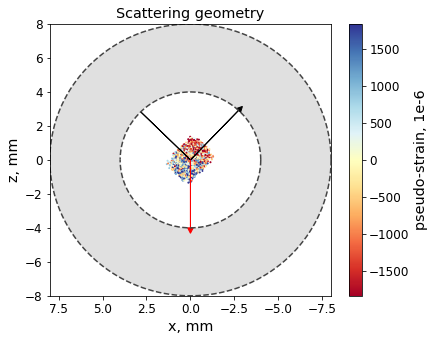

Figure saved in C:\Users\saroun\Documents\stressfit\output\scene_scene.png.


In [8]:
comm.plot_scene(3000, filename='scene.png', rang=[16, 16], proj='xz')

## Calculate resolution and pseudostrain

Provide the scan range and calculate pseudo-strains for it, using the command `report_pseudo_strains()`. This function calculates the "as-measured" strain and intensity by making convolution of the sampling events with the sample, assuming zero intrinsic strain and uniform scattering intensity.

Provide the `scan_range` and output `filename` as the 1st and 2nd arguments.
Other optional arguments are:
- `nev` : number of events to use
- `intensity` : if true, show also the intensity profile.

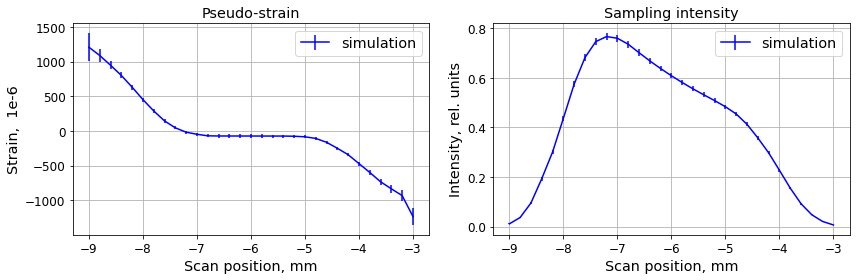

In [9]:
# Define scan range in mm: minimum, maximum and number of steps.
scan_range = [-9, -3, 31]
# Calculate and plot (use ; to suppress the returned value print)
comm.report_pseudo_strains(scan_range, '', nev=3000, intensity=True);

Calculate and plot spatial resolution characteristics, using the command `report_resolution()`.

This function calculates the size and centre of gravity (CoG) of the actual sampling distribution at given scan positions.

Provide the `scan_range` and output `filename` as the 1st and 2nd arguments.
Other optional arguments are:
- `nev` : number of events to use
- `cog` : if true, plot also the xyz positions of the sampling CoG.

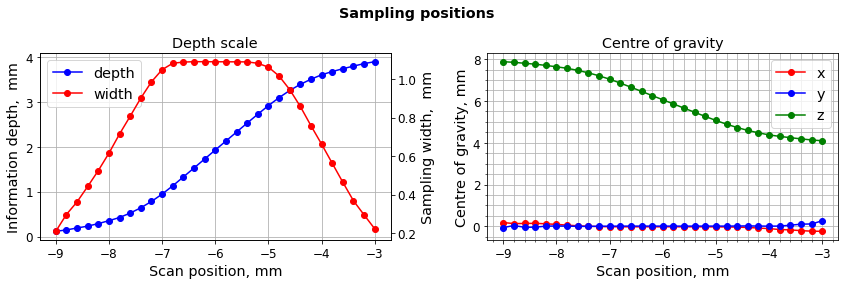

In [10]:
comm.report_resolution(scan_range, '', nev=3000, cog=True)

## Load input data

Below, define file names for the input data: measured strain and intensity. They should be in 3-column text format with scan position, value and error. 

By default, the previously defined geometry and sampling are used.You can associate the data with other geometry/sampling by providing the values as optional keyward arguments, or afterwards by setting corresponding 
values to the scan variable. 

For example: <code>scan['scandir'] = [1,0,0]</code>

At the end, the pseudo-strains and intensities are compared with the loaded data.

File loaded: D:\Saroun\git\stressfit_ecns\stressfit\resources\data\eps_SS_rad.dat
File loaded: D:\Saroun\git\stressfit_ecns\stressfit\resources\data\int_SS_rad.dat


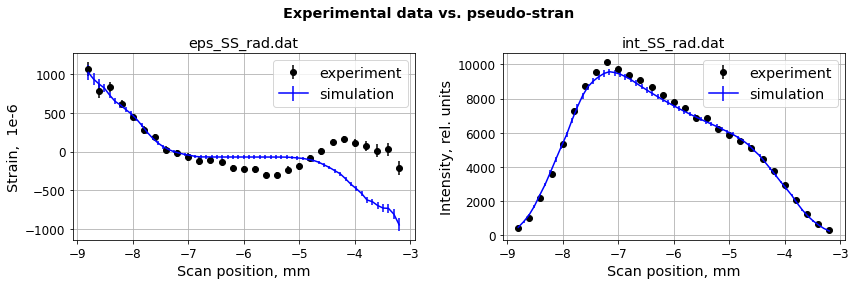

In [11]:
# Load and set the input data.
strain = 'eps_SS_rad.dat'
intensity = 'int_SS_rad.dat'
scan = comm.load_input(strain, intensity=intensity)
comm.set_scan(scan)   

# Calculate pseudo-strains and intensities and compare with the data.
comm.report_data_comparison(scan, nev=3000)


## Fit intensities  - setup model

Fitting of intensities allows to determine the variation of scattering 
probability and extinction with scan depth. It can also help to correct 
for any missfit between the encoder positions (stored in the data file) 
and true surface position. 

Note that sometimes these effects can't be distinguished from each other. 
With a strong variation of scattering probability 
(e.g. due to a greadient in texture or composition near the surface), 
it is not possible to reliably determine the surface position and extinction 
just from the intensity variation. Then some of the parameters must be 
determined independently and fixed for fitting. 
On the other hand, it is the product of extinction and scattering probability 
distributions which affects pseudo-strains, therefore they do not need to be 
exactly distinguished.

*NOTE*:
    
Scattering probability and strain distributions are defined on the depth scale.
Definition of the <i>depth</i> depends on the sample shape. For plates, it is 
the distance to the upper surface (in local coordinates of the sample). 
For sphers and cylinders, it is the distance from the curved surface 
(the outer one in the case of hollow shapes). 
For complex samples like ETubes, the 'depth' is a position inside the sample 
projected on the scan direction.

### Distribution model

The depth distributions are modelled as a set of points interpolated by 
splines of selected order (1 to 3). Define below a minimum number of depth 
and intensity values which gives a satisfactory estimate of the intensity 
variation. Obviously, the intensity values should be kept constant for 
homogeneous materials.

Define the `x`, `y` distribution values and associated fit-flags. For example,
`fitx=1` means a free x-variable, 0 means fixed.

`x` = depth values in mm  
`y` = intrinsic scattering intensity in rel. units  

In addition, define the method for `interpolation` between the nodes.
Use one of `natural`,`clamped`, `PCHIP`, `Akima`. See documentation in the lmfit package. 

### Scaling

Set scaling parameters A, B and zc, and corresponding fit-flags. 
The scaling formula is `y_scaled = A*y(z-zc) + B`.

### Fit configuration

Following parameters control the fitting process:

`maxiter` = Maximum number of iterations  
`bootstrap` = Use bootstrap method for estimation of confidence limits?  
`loops` = Set loops for the number of bootstrap cycles.  
`areg` = Regularization parameter  
`runIFit` = Set False to skip the intensity fit

### Initial estimate
The command `run_fit_guess` below executes the simple fit estimate (without the slower convolution process).
If necessary, adjust the above parameters to improve the initial model, and execute the block below again.

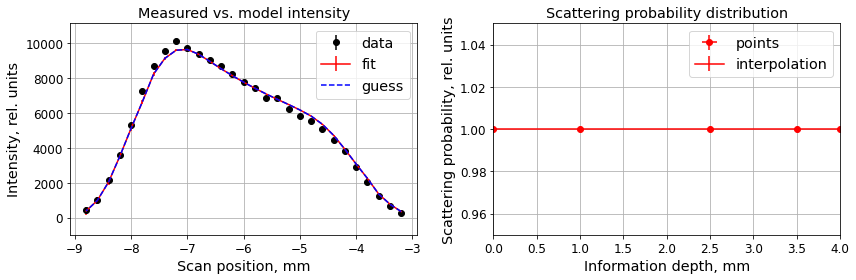

In [12]:
# Distribution model
distribution = {
    'x':    [0., 1., 2.5, 3.5, 4],
    'fitx': [0, 0, 0, 0, 0],
    'y':    [1., 1., 1., 1., 1.],
    'fity': [0, 0, 0, 0, 0]
    }
interpolation = 'natural'

# Scaling
scaling = {
    'A':  20000,
    'B':  0,
    'zc': 0.05
    }
f_scaling = {
    'fA':  1,
    'fB':  0,
    'fzc': 1
    }   

# Maximum number of iterations
maxiter = 100
# Use bootstrap method for estimation of confidence limits?
bootstrap = False
# Set loops for the number of bootstrap cycles.
loops = 3
# regularization parameter
areg = 3
# Set False to skip intensity fit
runIFit = True

"""Commands to define the fitting model."""
ifit = comm.define_ifit(scan, distribution, 3000)
comm.define_scaling(ifit, scaling, f_scaling)
ifit.setInterpModel(interpolation)

"""Guess fit."""
if runIFit:
    comm.run_fit_guess(ifit, maxiter=maxiter, ar=areg, outname='')


## Fit intensities - run and report results


Starting fit for < 100 iterations.
eval=0, chi2=56.2265, reg=2.13163e-07
eval=4, chi2=44.2214, reg=7.10543e-08
eval=6, chi2=44.2107, reg=1.42109e-07
eval=12, chi2=44.1771, reg=1.42109e-07
eval=14, chi2=44.1292, reg=1.42109e-07
eval=15, chi2=44.1043, reg=1.42109e-07
eval=22, chi2=44.1026, reg=7.10543e-08
eval=26, chi2=44.1024, reg=7.10543e-08
eval=29, chi2=44.1022, reg=0
Finished: FoM=44.1022, chi2=44.1022, reg=0


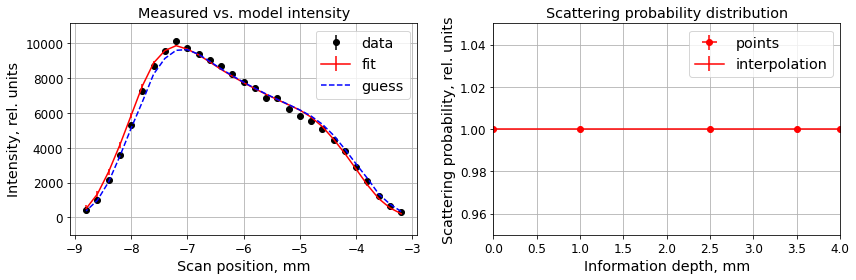

Figure saved in C:\Users\saroun\Documents\stressfit\output\int_SS_rad_fit.png
Model saved in C:\Users\saroun\Documents\stressfit\output\int_SS_rad_model.dat
Fit saved in C:\Users\saroun\Documents\stressfit\output\int_SS_rad_fit.dat
Log saved in C:\Users\saroun\Documents\stressfit\output\int_SS_rad.log


In [13]:
if runIFit:
    comm.run_fit(ifit, maxiter=maxiter, ar=areg, bootstrap=bootstrap, 
                 loops=loops, outname=scan['intfile'])

## Fit strain - setup model

Fitting of strain depth distribution is similar to the above procedure for 
fitting intensities. The scattering probability distribution determined 
above will be automatically taken into account in modelling of 
pseudo-strains below.

The depth distributions are modelled as a set of points 
(depth, strain) interpolated by splines of selected order (1 to 3).
Define below a minimum number of depth and strain values which is required
to gives a satisfactory estimate of the strain distribution. 
 
Define the `x`, `y` distribution values and associated fit-flags. For example,
`fitx=1` means a free x-variable, 0 means fixed.

`x` = depth values in mm  
`y` = strain in 1e-6 units   

The 1st and last x-value should always be fixed ...

In addition, define the method for `interpolation` between the nodes.
Use one of `natural`,`clamped`, `PCHIP`, `Akima`. See documentation in the lmfit package. 

### Fit configuration

Following parameters control the fitting process:

`maxiter` = Maximum number of iterations  
`maxguess` = Maximum iterations for guess fit.
`bootstrap` = Use bootstrap method for estimation of confidence limits?  
`loops` = Set loops for the number of bootstrap cycles.  
`areg` = Regularization parameter  
`aregs` = A list of regularization factors to scan through
`runSFit` = Set False to skip the strain fit
`runReg` = Run regularization loop?

### Initial estimate
The command `run_fit_guess` below executes the simple fit estimate (without the slower convolution process).
If necessary, adjust the above parameters to improve the initial model, and execute the block below again.


Using surface position: -0.0221764



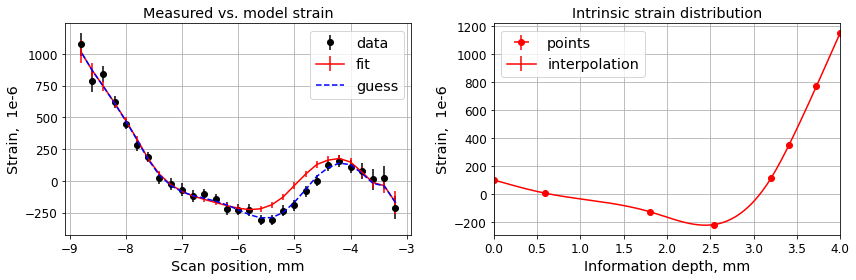

In [14]:
distribution = {
    'x':   [0., 1., 2.0 , 2.5, 3.0 , 3.5 , 3.7 ,  4.],
    'fitx': [0] + 6*[1] + [0],
    'y':  8*[0],
    'fity': 8*[1]
    }
interpolation = 'natural'

# You can use surface position from the intensity fit:
zc = ifit.params['xc'].value
print('Using surface position: {:g}\n'.format(zc))

"""Commands to define the fitting model."""
sfit = comm.define_sfit(scan, distribution, 3000, z0=zc)
sfit.setInterpModel(interpolation)

# Use bootstrap method for estimation of confidence limits?
bootstrap = True
# Set loops for the number of bootstrap cycles.
loops = 3
# Define a list of regularization factors:
aregs = [1, 2, 3, 4, 5]
# maximum iterations for guess fit
maxguess = 100
# maximum iterations for fit
maxiter = 250
# Run regularization loop?
runReg = True
# Run strain fit?
runSFit = True

# Run guess fit with given parameters (see docs for run_fit_guess)
if runSFit:
    comm.run_fit_guess(sfit, maxiter=maxguess, ar=areg, outname='')

### Run regularization loop

Regularization is necessary to avoid overfitting. It introduces additional penalty for non-smooth solutions (minimizes 2nd derivative of the distribution). Its weight is defined by the `areg` parameter. Usually, the optimum value of `areg` is somewhere bewteen 0 and 5. To acieve an optimal result, a scan with reguilarization parameter values should be done (takes long). For this set above  `runReg=True` and define the list of `values in `aregs`. 


Loop 1/5, ar=1
Starting fit for < 200 iterations.
eval=0, chi2=1035.78, reg=32.9114
eval=4, chi2=1035.78, reg=293.079
eval=6, chi2=1035.77, reg=865.385
eval=8, chi2=1024.34, reg=117931
eval=9, chi2=994.572, reg=226105
eval=16, chi2=433.03, reg=4.92801e+08
eval=17, chi2=362.69, reg=3.75842e+08
eval=31, chi2=8.49208, reg=4.77393e+08
eval=34, chi2=8.48323, reg=4.77389e+08
eval=35, chi2=8.24717, reg=4.65611e+08
eval=44, chi2=8.09316, reg=4.5188e+08
eval=47, chi2=0.511027, reg=2.83413e+07
eval=49, chi2=0.509719, reg=2.8363e+07
eval=54, chi2=0.504368, reg=2.83915e+07
eval=55, chi2=0.500081, reg=2.82651e+07
eval=63, chi2=0.450261, reg=2.72922e+07
eval=68, chi2=0.45026, reg=2.72674e+07
eval=69, chi2=0.450577, reg=2.64072e+07
eval=79, chi2=0.448567, reg=2.69096e+07
eval=84, chi2=0.448565, reg=2.68654e+07
eval=94, chi2=0.448387, reg=2.63204e+07
eval=99, chi2=0.448393, reg=2.62909e+07
eval=110, chi2=0.448056, reg=2.62679e+07
eval=115, chi2=0.448069, reg=2.6245e+07
eval=126, chi2=0.447988, reg=2.6

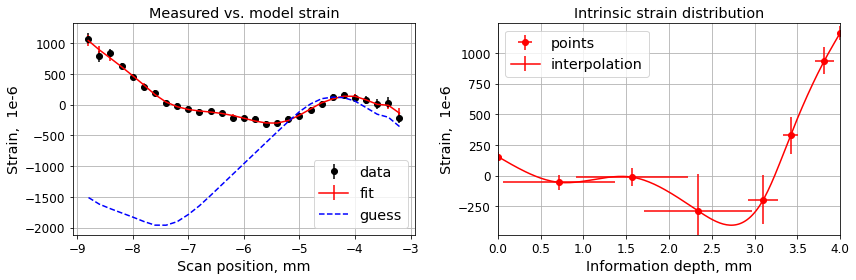

 
Loop 2/5, ar=2
Starting fit for < 200 iterations.
eval=0, chi2=1035.78, reg=32.9114
eval=4, chi2=1035.78, reg=293.079
eval=6, chi2=1035.77, reg=865.385
eval=8, chi2=1024.34, reg=117931
eval=9, chi2=994.572, reg=226105
eval=16, chi2=499.242, reg=6.41415e+08
eval=17, chi2=399.396, reg=4.73942e+08
eval=31, chi2=1.83268, reg=3.08556e+07
eval=35, chi2=1.8307, reg=3.06725e+07
eval=46, chi2=0.666004, reg=1.90115e+07
eval=47, chi2=0.663483, reg=1.88186e+07
eval=48, chi2=0.659339, reg=1.90934e+07
eval=52, chi2=0.661068, reg=1.85477e+07
eval=54, chi2=0.653687, reg=1.89282e+07
eval=58, chi2=0.65594, reg=1.74054e+07
eval=61, chi2=0.526126, reg=1.53237e+07
eval=63, chi2=0.524857, reg=1.53831e+07
eval=65, chi2=0.521713, reg=1.52338e+07
eval=73, chi2=0.521836, reg=1.48223e+07
eval=76, chi2=0.499567, reg=1.56439e+07
eval=78, chi2=0.498634, reg=1.56965e+07
eval=82, chi2=0.498376, reg=1.55112e+07
eval=88, chi2=0.497474, reg=1.52609e+07
eval=93, chi2=0.48208, reg=1.55349e+07
eval=98, chi2=0.48239, reg=

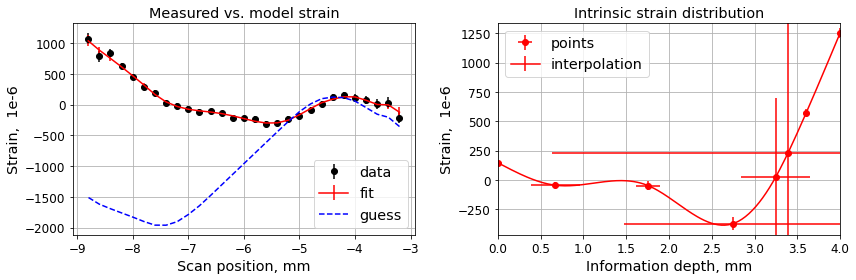

 
Loop 3/5, ar=3
Starting fit for < 200 iterations.
eval=0, chi2=1035.78, reg=32.9114
eval=4, chi2=1035.78, reg=293.079
eval=6, chi2=1035.77, reg=865.385
eval=8, chi2=1024.34, reg=117931
eval=9, chi2=994.572, reg=226105
eval=16, chi2=511.486, reg=5.73009e+08
eval=17, chi2=408.325, reg=4.05426e+08
eval=31, chi2=3.81698, reg=1.38585e+07
eval=32, chi2=3.76328, reg=1.37484e+07
eval=46, chi2=0.758261, reg=1.27484e+07
eval=48, chi2=0.750564, reg=1.27913e+07
eval=51, chi2=0.758418, reg=1.26507e+07
eval=56, chi2=0.749144, reg=1.26741e+07
eval=59, chi2=0.742199, reg=1.15268e+07
eval=61, chi2=0.740622, reg=1.02274e+07
eval=63, chi2=0.73347, reg=1.0272e+07
eval=70, chi2=0.730981, reg=1.02934e+07
eval=71, chi2=0.730376, reg=1.00395e+07
eval=93, chi2=0.729431, reg=9.99772e+06
Finished: FoM=1.7292, chi2=0.729431, reg=9.99772e+06


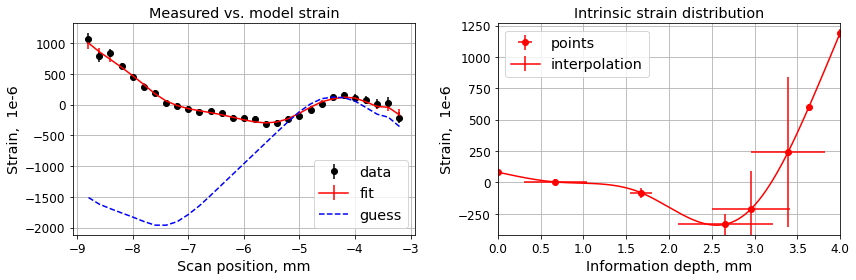

 
Loop 4/5, ar=4
Starting fit for < 200 iterations.
eval=0, chi2=1035.78, reg=32.9114
eval=4, chi2=1035.78, reg=293.079
eval=6, chi2=1035.77, reg=865.385
eval=8, chi2=1024.34, reg=117931
eval=9, chi2=994.572, reg=226105
eval=16, chi2=462.173, reg=3.1751e+08
eval=17, chi2=397.55, reg=2.39403e+08
eval=31, chi2=45.5197, reg=2.84548e+07
eval=33, chi2=45.6384, reg=2.81981e+07
eval=36, chi2=45.489, reg=2.8326e+07
eval=39, chi2=43.0507, reg=2.6596e+07
eval=46, chi2=2.58917, reg=5.83736e+06
eval=48, chi2=2.58008, reg=5.8395e+06
eval=55, chi2=2.55449, reg=5.84832e+06
eval=58, chi2=2.54923, reg=5.5302e+06
eval=63, chi2=2.4717, reg=5.12031e+06
eval=65, chi2=2.46259, reg=5.12796e+06
eval=67, chi2=2.51204, reg=5.06174e+06
eval=75, chi2=2.44515, reg=5.08631e+06
eval=78, chi2=2.58058, reg=4.30041e+06
eval=81, chi2=2.58048, reg=4.3005e+06
eval=82, chi2=2.64912, reg=4.21761e+06
eval=89, chi2=2.61781, reg=4.24669e+06
eval=94, chi2=2.7516, reg=4.00746e+06
eval=97, chi2=2.75131, reg=4.00774e+06
eval=98, c

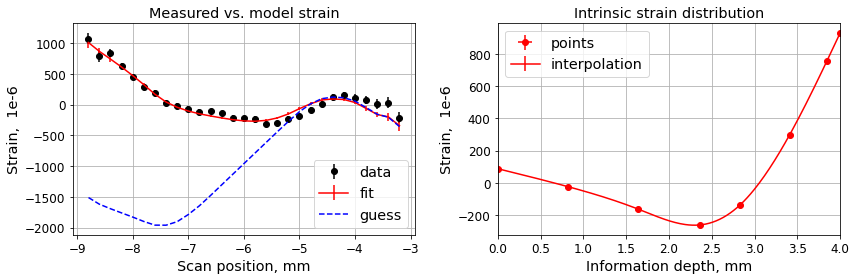

 
Loop 5/5, ar=5
Starting fit for < 200 iterations.
eval=0, chi2=1035.78, reg=32.9114
eval=6, chi2=1035.77, reg=865.385
eval=8, chi2=1024.34, reg=117931
eval=9, chi2=994.572, reg=226105
eval=16, chi2=389.839, reg=2.7234e+07
eval=17, chi2=380.672, reg=2.65123e+07
eval=20, chi2=390.062, reg=2.15621e+07
eval=31, chi2=14.8034, reg=1.07256e+07
eval=32, chi2=15.8175, reg=9.47895e+06
eval=45, chi2=14.7203, reg=9.0328e+06
eval=46, chi2=11.0059, reg=751128
eval=49, chi2=10.9855, reg=752849
eval=51, chi2=11.0191, reg=741737
eval=64, chi2=11.1381, reg=726849
eval=66, chi2=11.1394, reg=726710
eval=80, chi2=11.154, reg=725112
eval=96, chi2=11.1589, reg=724620
eval=111, chi2=11.1615, reg=724340
eval=126, chi2=11.1627, reg=724205
eval=141, chi2=11.1633, reg=724136
eval=156, chi2=11.1636, reg=724101
Finished: FoM=18.4046, chi2=11.1636, reg=724101


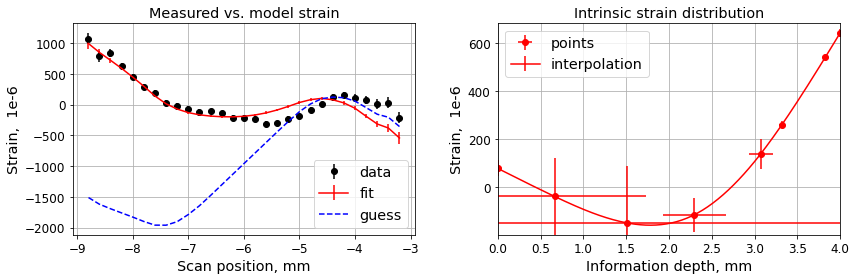

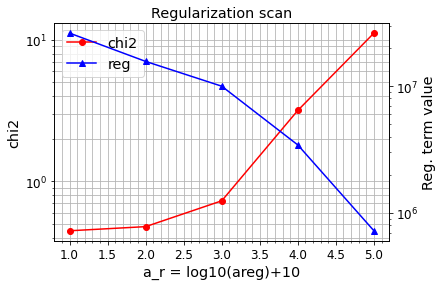

areg	FoM	chi2	reg
1e-09	0.474221	0.447998	2.62233e+07
1e-08	0.635998	0.479187	1.56811e+07
1e-07	1.7292	0.729431	9.99772e+06
1e-06	6.61419	3.17465	3.43954e+06
1e-05	18.4046	11.1636	724101



In [15]:
if runSFit and runReg:
    comm.run_fit_reg(sfit, maxiter=maxiter, ar=aregs, outname='')

##  Fit strain - run final fit

Choose below the optimum regularization value (areg) and run the final fit.

Starting fit for < 200 iterations and 3 loops for error estimate.
eval=0, chi2=613.03, reg=32.9114
eval=6, chi2=613.024, reg=865.385
eval=8, chi2=605.013, reg=117931
eval=9, chi2=589.107, reg=226105
eval=16, chi2=282.938, reg=5.77507e+08
eval=17, chi2=232.579, reg=4.42616e+08
eval=31, chi2=1.6739, reg=1.09995e+07
eval=32, chi2=1.63324, reg=1.09799e+07
eval=46, chi2=1.34656, reg=8.16622e+06
eval=48, chi2=1.34016, reg=8.21311e+06
eval=55, chi2=1.33786, reg=8.23068e+06
eval=56, chi2=1.35162, reg=7.96351e+06
eval=62, chi2=1.34586, reg=7.86344e+06
eval=63, chi2=1.34239, reg=7.88484e+06
eval=92, chi2=1.34194, reg=7.8735e+06
eval=93, chi2=1.33984, reg=7.89345e+06
eval=103, chi2=1.34213, reg=7.87054e+06
eval=109, chi2=1.34355, reg=7.83567e+06
eval=110, chi2=1.34142, reg=7.85585e+06
eval=125, chi2=1.34437, reg=7.81159e+06
eval=126, chi2=1.34224, reg=7.83179e+06
eval=141, chi2=1.34531, reg=7.79904e+06
eval=142, chi2=1.34317, reg=7.81924e+06
eval=156, chi2=1.34579, reg=7.79267e+06
eval=157, chi2=

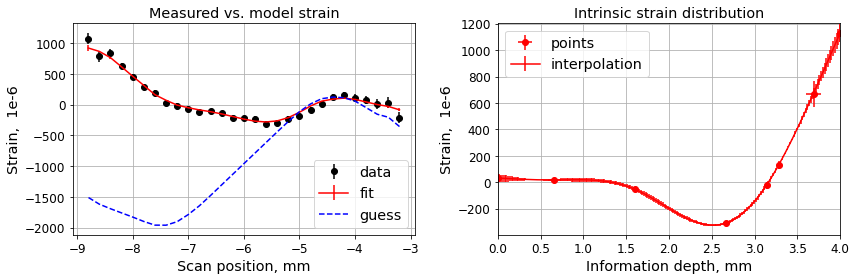

Figure saved in C:\Users\saroun\Documents\stressfit\output\eps_SS_rad_fit.png
Model saved in C:\Users\saroun\Documents\stressfit\output\eps_SS_rad_model.dat
Fit saved in C:\Users\saroun\Documents\stressfit\output\eps_SS_rad_fit.dat
Log saved in C:\Users\saroun\Documents\stressfit\output\eps_SS_rad.log


In [16]:
areg = 3
if runSFit:
    comm.run_fit(sfit, maxiter=maxiter, ar=areg, outname=scan['epsfile'], 
                 bootstrap=bootstrap, loops=loops)